In [1]:
import simpy
import random
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
# 1 - продуктовый №1
# 2 - продуктовый №2
# 3 - аптека
# 4 - киосок
# 5 - парихмахерская
Company_name = {1: 'grocery store 1', 2: 'grocery store 2', 3: 'Apteka', 4: 'Kiosk', 5: 'Barbershop'}

def to_time(time_min):
    return str(datetime.datetime(2020, 1, 1) + datetime.timedelta(minutes=time_min))[:19]

def get_random(mu, sigma):
    x = random.gauss(mu, sigma)
    if x >= 0:
        return x
    else:
        return 0

In [2]:
df = pd.DataFrame(columns=['Company_id','id_visiter','time_enter','time_exit'])
random_seed = 4545
Mu_visiter, Sigma_visiter = 5, 2 #среднее время создания посетителя и дисперсия
Mu_cash, Sigma_cash = 5, 2 #обуслуживание на кассе в магаззине и в аптеке
Num_cass_store = 3 #количество касс в магазине
Num_cass_apteka = 2 #количество касс в аптеке
Num_cass_kiosk = 1 # количество касс в киоске
Num_barbers = 2 # количество раб. в парихмахерской
Mu_kiosk, Sigma_kiosk = 3, 2 #обуслуживание на кассе киоске
Mu_barber, Sigma_barber = 20, 2 #время стрижки
#будем бросать кубик
N_store_1 = [1, 2, 3]
N_store_2 = [4, 5, 6]
N_apteka = [7]
N_barbershop =[8]
N_kiosk = [9]
N_exit = [0]
SIM_TIME = 60*24*31

class street(object):
    #наша улица
    def __init__(self, env):
        self.env = env
        self.store_1 = simpy.Resource(env, Num_cass_store)
        self.store_2 = simpy.Resource(env, Num_cass_store)
        self.apteka = simpy.Resource(env, Num_cass_apteka)
        self.kiosk = simpy.Resource(env, Num_cass_kiosk)
        self.barbershop = simpy.Resource(env, Num_barbers)
    def service_store(self, visiter):
        yield self.env.timeout(get_random(Mu_cash, Sigma_cash)) #заставляем ждать посетителя на кассе
    def service_kiosk(self, visiter):
        yield self.env.timeout(get_random(Mu_kiosk, Sigma_kiosk)) #заставляем ждать посетителя в киоске
    def service_barbershop(self, visiter):
        yield self.env.timeout(get_random(Mu_barber, Sigma_barber)) #заставляем ждать посетителя в парихмхерской
    
def visiter(env, name, st):
    global df
    #print(print('%s появился %.2f.' % (name, env.now)))
    visit_map = [0]
    while True:
        choice = random.randrange(10) #броасаем кубик чтобы посмотреть, куда идти
        #print(choice)
        #print(visit_map)
        t = env.now
        if choice in visit_map:  #идем на выход
            #print('%s свалил на выход, выпало %.2f.' % (name, env.now))
            return
        
        #продуктовый 1
        elif choice in N_store_1:
            #print(print('%s пришел в магаз 1 %.2f.' % (name, env.now)))
            #print(get_random(10, 5))
            with st.store_1.request() as req:
                result = yield req | env.timeout(0) #увидел что все занято
                if req in result:
                    yield env.process(st.service_store(name))
                    #print('%s свалил после обслуживания 1  %.2f.' % (name, env.now))
                    #print('%s пошел подальше от очередей 1 %.2f.' % (name, env.now))
            visit_map.extend(N_store_1)
            df = df.append({'Company_id':1, 'id_visiter':name, 'time_enter': t, 'time_exit':env.now}, ignore_index=True)
            continue
            
        #продуктовый 2    
        elif choice in N_store_2:
            #print(print('%s пришел в магаз 2 %.2f.' % (name, env.now)))
            #print(get_random(10, 5))
            with st.store_2.request() as req:
                result = yield req | env.timeout(0) #увидел что все занято
                if req in result:
                    yield env.process(st.service_store(name))
                    #print('%s свалил после обслуживания 2  %.2f.' % (name, env.now))
                    #print('%s пошел подальше от очередей 2 %.2f.' % (name, env.now))
            visit_map.extend(N_store_2)
            df = df.append({'Company_id':2, 'id_visiter':name, 'time_enter': t, 'time_exit':env.now}, ignore_index=True)
            continue
            
        #аптека     
        elif choice in N_apteka:
            #print(print('%s пришел в аптеку %.2f.' % (name, env.now)))
            with st.apteka.request() as req:
                result = yield req | env.timeout(0) #увидел что все занято
                if req in result:
                    yield env.process(st.service_store(name))
                    #print('%s свалил после обслуживания в аптеке  %.2f.' % (name, env.now))
                    #print('%s пошел подальше от очередей в апетеке %.2f.' % (name, env.now))
            visit_map.extend(N_apteka)
            df = df.append({'Company_id':3, 'id_visiter':name, 'time_enter': t, 'time_exit':env.now}, ignore_index=True)
            continue
        
        #киосок 
        elif choice in N_kiosk:
            #print(print('%s пришел в киоск %.2f.' % (name, env.now)))
            with st.kiosk.request() as req:
                result = yield req | env.timeout(0) #увидел что все занято
                if req in result:
                    yield env.process(st.service_store(name))
                    #print('%s свалил после обслуживания в киоске  %.2f.' % (name, env.now))
                    #print('%s пошел подальше от очередей в киоске %.2f.' % (name, env.now))
            visit_map.extend(N_kiosk)
            df = df.append({'Company_id':4, 'id_visiter':name, 'time_enter': t, 'time_exit':env.now}, ignore_index=True)
            continue
            
        #парихмахерская    
        elif choice in N_barbershop:
            #print(print('%s пришел в парихмахерскую %.2f.' % (name, env.now)))
            with st.barbershop.request() as req:
                result = yield req | env.timeout(0) #увидел что все занято
                if req in result:
                    yield env.process(st.service_barbershop(name))
                    #print('%s свалил после обслуживания в парихмахерской  %.2f.' % (name, env.now))
                    #print('%s пошел подальше от очередей в парихмахерской %.2f.' % (name, env.now))
            visit_map.extend(N_barbershop)
            df = df.append({'Company_id':5, 'id_visiter':name, 'time_enter': t, 'time_exit':env.now}, ignore_index=True)
            continue
            
        

        
def setup(env):
    # Create the street
    Street = street(env)
    i = 1
    env.process(visiter(env, i, Street))
    while True:
        yield env.timeout(get_random(Mu_visiter, Sigma_visiter))
        #print('создался посетитель')
        i += 1
        env.process(visiter(env, i, Street))

random.seed(random_seed)
env = simpy.Environment()
env.process(setup(env))

env.run(until=SIM_TIME)

In [3]:
df['Company_id'] = df.Company_id.astype(int)
df['id_visiter'] = df.id_visiter.astype(int)
df['time_enter'] = df.time_enter.apply(lambda x: to_time(x))
df['time_exit'] = df.time_exit.apply(lambda x: to_time(x))
df['time_enter'] = pd.to_datetime(df['time_enter'])
df['time_exit'] = pd.to_datetime(df['time_exit'])

In [4]:
df

,Company_id,id_visiter,time_enter,time_exit
0,2,1,2020-01-01 00:00:00,2020-01-01 00:03:19
1,1,2,2020-01-01 00:07:04,2020-01-01 00:08:05
2,1,1,2020-01-01 00:03:19,2020-01-01 00:08:11
3,2,3,2020-01-01 00:11:02,2020-01-01 00:16:10
4,3,3,2020-01-01 00:16:10,2020-01-01 00:19:36
5,1,3,2020-01-01 00:19:36,2020-01-01 00:21:27
6,2,6,2020-01-01 00:21:01,2020-01-01 00:24:08
7,2,5,2020-01-01 00:18:02,2020-01-01 00:24:32
8,1,7,2020-01-01 00:25:50,2020-01-01 00:30:08
9,1,6,2020-01-01 00:24:08,2020-01-01 00:30:36


In [5]:
df.to_csv('visitors.csv')

In [6]:
df.Company_id.value_counts()

2    5073
1    5042
3    2182
5    2158
4    2153
Name: Company_id, dtype: int64

In [7]:
df[df.time_enter == df.time_exit].id_visiter.count() #посмотрели на очереди и ушли

886

In [8]:
df.id_visiter.value_counts().value_counts() # кто-то все заведения сумел посетить

2    2842
1    2653
3    1769
4     631
5      88
Name: id_visiter, dtype: int64

In [9]:
def visualization(choice_company, df):
    df1 = df[df.Company_id == choice_company] #все те кто посетил компанию
    df2 = df1.merge(df, how = 'left', on = 'id_visiter')
    df_last = df2[(df2.Company_id_x != df2.Company_id_y) &
    (df2.time_enter_x >= df2.time_exit_y) & #время входа > время выхода из прошлого заведения
    ((df2.time_enter_x - df2.time_exit_y) < datetime.timedelta(hours=1))].Company_id_y.value_counts() #время входа - выхода < часа
    df_last = df_last.rename_axis('company').reset_index(name='visit_before')
    
    df_after = df2[(df2.Company_id_x != df2.Company_id_y) & 
    (df2.time_exit_x <= df2.time_enter_y) &
    (df2.time_enter_y - df2.time_enter_x < datetime.timedelta(hours=1))].Company_id_y.value_counts()
    df_after = df_after.rename_axis('company').reset_index(name='visit_after')
    df_after['visit_after'] = df_after.visit_after.apply(lambda x: -x)
    all_data = df_last.merge(df_after, how = 'left', on = 'company')
    all_data['company'] = all_data.company.apply(lambda x: Company_name[x])
    
    print('для компании ', str(Company_name[choice_company]))
    sns.set(style='darkgrid')
    df2 = pd.melt(all_data, id_vars ='company', var_name='type of visiter', value_name='change in the output' )
    fig, ax = plt.subplots(sharey=True, figsize=(10,5))
    for typ, df in zip(df2['type of visiter'].unique(),df2.groupby('type of visiter')):
        ax.barh(df[1]['company'], df[1]['change in the output'], height=1, label=typ)

    formatter = matplotlib.ticker.NullFormatter()
    ax.xaxis.set_major_formatter (formatter)
    for i, v in enumerate(df2['change in the output'][:4]):
        ax.text(v - 250, i- 0.1, str(v), color='black', fontweight='bold', fontsize=16)
    for i, v in enumerate(df2['change in the output'][4:]):
        ax.text(v + 100, i - 0.1, str(abs(v)), color='black', fontweight='bold', fontsize=16)
    ax.legend(title = 'type of visiter')  
    plt.show()
    

для компании  grocery store 1


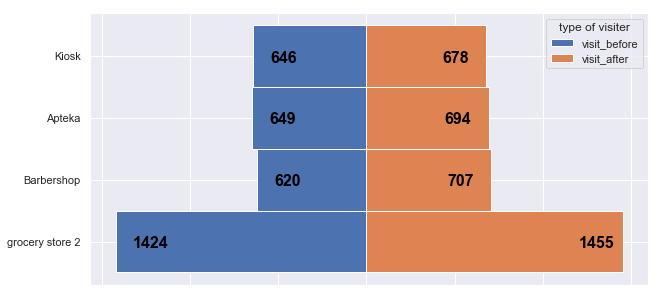

для компании  grocery store 2


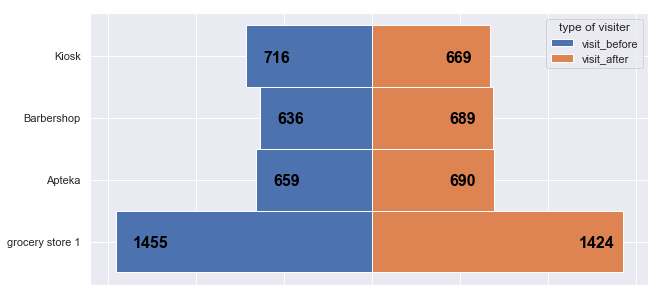

для компании  Apteka


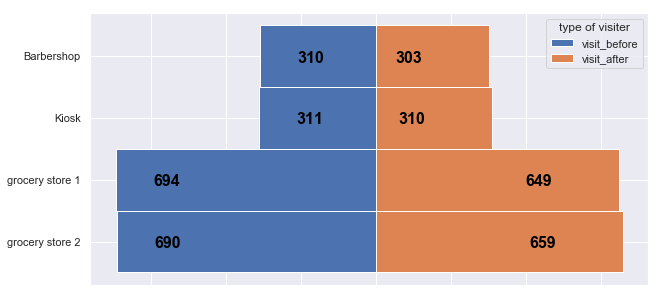

для компании  Kiosk


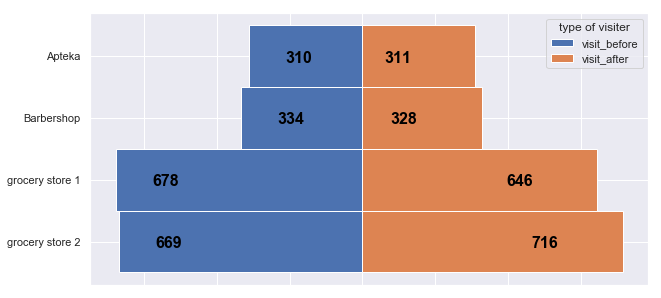

для компании  Barbershop


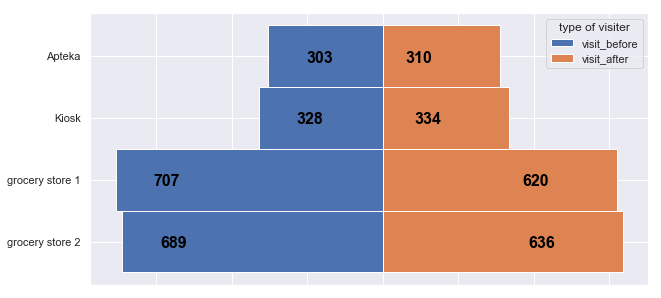

In [10]:
for i in range(1,6):
    visualization(i, df)